In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
from torch.utils.data import random_split
import glob

### Import dataset and put into dataloader

In [14]:
##### import CIFAR-10 dataset into trainset, testset# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

batchSize = 20

trainset_color = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=True,
                                        download=False, transform=transform_color)
trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=batchSize,
                                          shuffle=False, num_workers=2)

testset_color = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=False,
                                       download=False, transform=transform_color)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


**Splitting the training dataset for training and validation**

In [15]:

##### import CIFAR-10 dataset into trainset, testset# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

batchSize = 100

trainset_color = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=True,
                                        download=False, transform=transform_color)


testset_color = torchvision.datasets.CIFAR10(root='../input/cifar10-python', train=False,
                                       download=False, transform=transform_color)

torch.manual_seed(43)
val_size = 5000
train_size = len(trainset_color) - val_size

trainset_color, valset_color = random_split(trainset_color, [train_size, val_size])
print(len(trainset_color), len(valset_color))

valloader_color = torch.utils.data.DataLoader(valset_color, batch_size=batchSize,
                                          shuffle=False, num_workers=2)

trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=batchSize,
                                          shuffle=False, num_workers=2)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=batchSize,
                                         shuffle=False, num_workers=2)
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)


45000 5000
cuda:0


### Pre-processing: Convert all rgb images to gray images

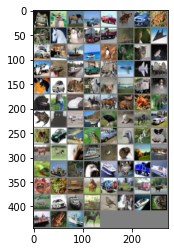

torch.Size([100, 3, 32, 32])


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_color))

# show dataiter shape
print(images_color.shape)

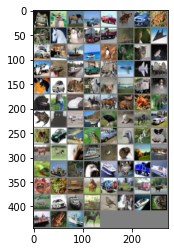

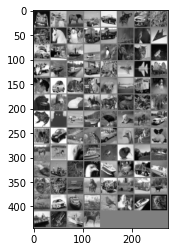

images_gray shape:  torch.Size([100, 1, 32, 32])


In [17]:
# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
images_gray = images_gray.reshape(batchSize,1,32,32)

imshow(torchvision.utils.make_grid(images_color))
imshow(torchvision.utils.make_grid(images_gray))
print("images_gray shape: ", images_gray.shape)

### Define the MLP network

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 32x32x3
        super(MLP_net, self).__init__()
        
        self.layer1 = nn.Linear(1024,1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.layer2 = nn.Linear(1024,3072)
        self.bn2 = nn.BatchNorm1d(3072)
        self.layer3 = nn.Linear(3072,3072)
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = self.layer3(x)
        return x
    '''
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    '''

mlp_net = MLP_net().to(device)

print("is cude: ", next(mlp_net.parameters()).is_cuda)

if os.path.exists("./saved_model/mlp.pt"):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load("./saved_model/mlp.pt"))

is cude:  True


### Define the loss function and optimizer

In [19]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard to save all training output logs

In [20]:

from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs_mlp/")

### Train the network

In [21]:

history_loss=[]
history_val_loss=[]
for epoch in range(500):  # loop over the dataset multiple times

    running_loss = 0.0
    num_training = 0
    for i, data_color in enumerate(trainloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, labels_color = data_color
        images_gray = rgb2gray_batch(images_color)
        # put data in gpu/cpu
        images_color = images_color.to(device)
        images_gray = images_gray.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        # input: images_gray
        images_gray = images_gray.view(images_gray.shape[0],-1)
        # print("images_gray: ", images_gray.shape)
        outputs = mlp_net(images_gray)
        # change the shape of images_color: [batchSize,3,32,32] -> [batchSize,3072]
        images_color = images_color.reshape(images_color.shape[0], -1) 
        loss = criterion(outputs, images_color)
        loss.backward()
        optimizer.step()
        # print output statistics
        running_loss += loss.item()
        j = 200             # print every 200 mini-batches
        if i % j == (j-1):     # print every 200 mini-batches
            print("trainingloss:",'[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / j))
            writer.add_scalar('Loss/train', running_loss/j, len(trainset_color)*epoch + i)
            history_loss.append(running_loss / j)
            running_loss = 0.0
    
    running_val_loss = 0.0
    for i, data_val_color in enumerate(valloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_val_color, labels_val_color = data_val_color
        images_val_gray = rgb2gray_batch(images_val_color)
        # put data in gpu/cpu
        images_val_color = images_val_color.to(device)
        images_val_gray = images_val_gray.to(device)
        
        # forward + backward + optimize
        # input: images_val_gray
        images_val_gray = images_val_gray.view(images_val_gray.shape[0],-1)
        # print("images_val_gray: ", images_val_gray.shape)
        outputs_val = mlp_net(images_val_gray)
        # change the shape of images_val_color: [batchSize,3,32,32] -> [batchSize,3072]
        images_val_color = images_val_color.reshape(images_val_color.shape[0], -1) 
        
        loss_val = criterion(outputs_val, images_val_color)
        
        # print output statistics
        running_val_loss += loss_val.item()
        
        
        j = 10           # print every 200 mini-batches #TODO mettre le meme j que au dessus
        if i % j == (j-1):     # print every 200 mini-batches
            print("validation",'[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_val_loss / j))
            writer.add_scalar('Loss/val', running_val_loss/j, len(valset_color)*epoch + i)
            history_val_loss.append(running_val_loss / j)
            
            running_val_loss = 0.0
writer.flush()
writer.close()
print('Finished Training')

trainingloss: [1,   200] loss: 0.423
trainingloss: [1,   400] loss: 0.258
validation [1,    10] loss: 0.212
validation [1,    20] loss: 0.209
validation [1,    30] loss: 0.209
validation [1,    40] loss: 0.213
validation [1,    50] loss: 0.207
trainingloss: [2,   200] loss: 0.195
trainingloss: [2,   400] loss: 0.171
validation [2,    10] loss: 0.162
validation [2,    20] loss: 0.158
validation [2,    30] loss: 0.159
validation [2,    40] loss: 0.162
validation [2,    50] loss: 0.157
trainingloss: [3,   200] loss: 0.155
trainingloss: [3,   400] loss: 0.146
validation [3,    10] loss: 0.143
validation [3,    20] loss: 0.140
validation [3,    30] loss: 0.141
validation [3,    40] loss: 0.144
validation [3,    50] loss: 0.138
trainingloss: [4,   200] loss: 0.139
trainingloss: [4,   400] loss: 0.134
validation [4,    10] loss: 0.133
validation [4,    20] loss: 0.130
validation [4,    30] loss: 0.131
validation [4,    40] loss: 0.134
validation [4,    50] loss: 0.128
trainingloss: [5,   200]

trainingloss: [34,   200] loss: 0.083
trainingloss: [34,   400] loss: 0.083
validation [34,    10] loss: 0.084
validation [34,    20] loss: 0.082
validation [34,    30] loss: 0.083
validation [34,    40] loss: 0.084
validation [34,    50] loss: 0.080
trainingloss: [35,   200] loss: 0.083
trainingloss: [35,   400] loss: 0.082
validation [35,    10] loss: 0.084
validation [35,    20] loss: 0.082
validation [35,    30] loss: 0.082
validation [35,    40] loss: 0.084
validation [35,    50] loss: 0.080
trainingloss: [36,   200] loss: 0.082
trainingloss: [36,   400] loss: 0.082
validation [36,    10] loss: 0.083
validation [36,    20] loss: 0.081
validation [36,    30] loss: 0.082
validation [36,    40] loss: 0.083
validation [36,    50] loss: 0.079
trainingloss: [37,   200] loss: 0.082
trainingloss: [37,   400] loss: 0.081
validation [37,    10] loss: 0.082
validation [37,    20] loss: 0.081
validation [37,    30] loss: 0.081
validation [37,    40] loss: 0.082
validation [37,    50] loss: 0.

validation [66,    40] loss: 0.071
validation [66,    50] loss: 0.068
trainingloss: [67,   200] loss: 0.070
trainingloss: [67,   400] loss: 0.069
validation [67,    10] loss: 0.071
validation [67,    20] loss: 0.070
validation [67,    30] loss: 0.070
validation [67,    40] loss: 0.071
validation [67,    50] loss: 0.067
trainingloss: [68,   200] loss: 0.070
trainingloss: [68,   400] loss: 0.069
validation [68,    10] loss: 0.071
validation [68,    20] loss: 0.069
validation [68,    30] loss: 0.069
validation [68,    40] loss: 0.070
validation [68,    50] loss: 0.067
trainingloss: [69,   200] loss: 0.069
trainingloss: [69,   400] loss: 0.069
validation [69,    10] loss: 0.070
validation [69,    20] loss: 0.069
validation [69,    30] loss: 0.069
validation [69,    40] loss: 0.070
validation [69,    50] loss: 0.067
trainingloss: [70,   200] loss: 0.069
trainingloss: [70,   400] loss: 0.069
validation [70,    10] loss: 0.070
validation [70,    20] loss: 0.069
validation [70,    30] loss: 0.

validation [99,    30] loss: 0.062
validation [99,    40] loss: 0.063
validation [99,    50] loss: 0.060
trainingloss: [100,   200] loss: 0.062
trainingloss: [100,   400] loss: 0.062
validation [100,    10] loss: 0.063
validation [100,    20] loss: 0.062
validation [100,    30] loss: 0.062
validation [100,    40] loss: 0.063
validation [100,    50] loss: 0.060
trainingloss: [101,   200] loss: 0.062
trainingloss: [101,   400] loss: 0.061
validation [101,    10] loss: 0.063
validation [101,    20] loss: 0.062
validation [101,    30] loss: 0.062
validation [101,    40] loss: 0.063
validation [101,    50] loss: 0.060
trainingloss: [102,   200] loss: 0.062
trainingloss: [102,   400] loss: 0.061
validation [102,    10] loss: 0.063
validation [102,    20] loss: 0.062
validation [102,    30] loss: 0.062
validation [102,    40] loss: 0.062
validation [102,    50] loss: 0.060
trainingloss: [103,   200] loss: 0.062
trainingloss: [103,   400] loss: 0.061
validation [103,    10] loss: 0.063
validat

validation [131,    30] loss: 0.057
validation [131,    40] loss: 0.058
validation [131,    50] loss: 0.055
trainingloss: [132,   200] loss: 0.057
trainingloss: [132,   400] loss: 0.056
validation [132,    10] loss: 0.058
validation [132,    20] loss: 0.057
validation [132,    30] loss: 0.057
validation [132,    40] loss: 0.057
validation [132,    50] loss: 0.055
trainingloss: [133,   200] loss: 0.057
trainingloss: [133,   400] loss: 0.056
validation [133,    10] loss: 0.058
validation [133,    20] loss: 0.057
validation [133,    30] loss: 0.057
validation [133,    40] loss: 0.057
validation [133,    50] loss: 0.055
trainingloss: [134,   200] loss: 0.057
trainingloss: [134,   400] loss: 0.056
validation [134,    10] loss: 0.058
validation [134,    20] loss: 0.057
validation [134,    30] loss: 0.056
validation [134,    40] loss: 0.057
validation [134,    50] loss: 0.055
trainingloss: [135,   200] loss: 0.056
trainingloss: [135,   400] loss: 0.056
validation [135,    10] loss: 0.057
vali

validation [163,    30] loss: 0.053
validation [163,    40] loss: 0.054
validation [163,    50] loss: 0.052
trainingloss: [164,   200] loss: 0.053
trainingloss: [164,   400] loss: 0.053
validation [164,    10] loss: 0.054
validation [164,    20] loss: 0.053
validation [164,    30] loss: 0.053
validation [164,    40] loss: 0.054
validation [164,    50] loss: 0.052
trainingloss: [165,   200] loss: 0.053
trainingloss: [165,   400] loss: 0.052
validation [165,    10] loss: 0.054
validation [165,    20] loss: 0.053
validation [165,    30] loss: 0.053
validation [165,    40] loss: 0.053
validation [165,    50] loss: 0.052
trainingloss: [166,   200] loss: 0.053
trainingloss: [166,   400] loss: 0.052
validation [166,    10] loss: 0.054
validation [166,    20] loss: 0.053
validation [166,    30] loss: 0.053
validation [166,    40] loss: 0.053
validation [166,    50] loss: 0.052
trainingloss: [167,   200] loss: 0.053
trainingloss: [167,   400] loss: 0.052
validation [167,    10] loss: 0.054
vali

validation [195,    30] loss: 0.050
validation [195,    40] loss: 0.051
validation [195,    50] loss: 0.049
trainingloss: [196,   200] loss: 0.050
trainingloss: [196,   400] loss: 0.050
validation [196,    10] loss: 0.051
validation [196,    20] loss: 0.051
validation [196,    30] loss: 0.050
validation [196,    40] loss: 0.051
validation [196,    50] loss: 0.049
trainingloss: [197,   200] loss: 0.050
trainingloss: [197,   400] loss: 0.050
validation [197,    10] loss: 0.051
validation [197,    20] loss: 0.050
validation [197,    30] loss: 0.050
validation [197,    40] loss: 0.051
validation [197,    50] loss: 0.049
trainingloss: [198,   200] loss: 0.050
trainingloss: [198,   400] loss: 0.050
validation [198,    10] loss: 0.051
validation [198,    20] loss: 0.050
validation [198,    30] loss: 0.050
validation [198,    40] loss: 0.051
validation [198,    50] loss: 0.049
trainingloss: [199,   200] loss: 0.050
trainingloss: [199,   400] loss: 0.050
validation [199,    10] loss: 0.051
vali

validation [227,    30] loss: 0.048
validation [227,    40] loss: 0.049
validation [227,    50] loss: 0.047
trainingloss: [228,   200] loss: 0.048
trainingloss: [228,   400] loss: 0.048
validation [228,    10] loss: 0.049
validation [228,    20] loss: 0.049
validation [228,    30] loss: 0.048
validation [228,    40] loss: 0.049
validation [228,    50] loss: 0.047
trainingloss: [229,   200] loss: 0.048
trainingloss: [229,   400] loss: 0.048
validation [229,    10] loss: 0.049
validation [229,    20] loss: 0.049
validation [229,    30] loss: 0.048
validation [229,    40] loss: 0.048
validation [229,    50] loss: 0.047
trainingloss: [230,   200] loss: 0.048
trainingloss: [230,   400] loss: 0.048
validation [230,    10] loss: 0.049
validation [230,    20] loss: 0.048
validation [230,    30] loss: 0.048
validation [230,    40] loss: 0.048
validation [230,    50] loss: 0.047
trainingloss: [231,   200] loss: 0.048
trainingloss: [231,   400] loss: 0.048
validation [231,    10] loss: 0.049
vali

validation [259,    30] loss: 0.046
validation [259,    40] loss: 0.047
validation [259,    50] loss: 0.046
trainingloss: [260,   200] loss: 0.047
trainingloss: [260,   400] loss: 0.046
validation [260,    10] loss: 0.048
validation [260,    20] loss: 0.047
validation [260,    30] loss: 0.046
validation [260,    40] loss: 0.047
validation [260,    50] loss: 0.046
trainingloss: [261,   200] loss: 0.047
trainingloss: [261,   400] loss: 0.046
validation [261,    10] loss: 0.048
validation [261,    20] loss: 0.047
validation [261,    30] loss: 0.046
validation [261,    40] loss: 0.047
validation [261,    50] loss: 0.046
trainingloss: [262,   200] loss: 0.047
trainingloss: [262,   400] loss: 0.046
validation [262,    10] loss: 0.048
validation [262,    20] loss: 0.047
validation [262,    30] loss: 0.046
validation [262,    40] loss: 0.047
validation [262,    50] loss: 0.046
trainingloss: [263,   200] loss: 0.047
trainingloss: [263,   400] loss: 0.046
validation [263,    10] loss: 0.048
vali

validation [291,    30] loss: 0.045
validation [291,    40] loss: 0.046
validation [291,    50] loss: 0.045
trainingloss: [292,   200] loss: 0.045
trainingloss: [292,   400] loss: 0.045
validation [292,    10] loss: 0.046
validation [292,    20] loss: 0.046
validation [292,    30] loss: 0.045
validation [292,    40] loss: 0.046
validation [292,    50] loss: 0.045
trainingloss: [293,   200] loss: 0.045
trainingloss: [293,   400] loss: 0.045
validation [293,    10] loss: 0.046
validation [293,    20] loss: 0.046
validation [293,    30] loss: 0.045
validation [293,    40] loss: 0.045
validation [293,    50] loss: 0.045
trainingloss: [294,   200] loss: 0.045
trainingloss: [294,   400] loss: 0.045
validation [294,    10] loss: 0.046
validation [294,    20] loss: 0.046
validation [294,    30] loss: 0.045
validation [294,    40] loss: 0.045
validation [294,    50] loss: 0.044
trainingloss: [295,   200] loss: 0.045
trainingloss: [295,   400] loss: 0.045
validation [295,    10] loss: 0.046
vali

validation [323,    30] loss: 0.044
validation [323,    40] loss: 0.044
validation [323,    50] loss: 0.043
trainingloss: [324,   200] loss: 0.044
trainingloss: [324,   400] loss: 0.044
validation [324,    10] loss: 0.045
validation [324,    20] loss: 0.045
validation [324,    30] loss: 0.044
validation [324,    40] loss: 0.044
validation [324,    50] loss: 0.043
trainingloss: [325,   200] loss: 0.044
trainingloss: [325,   400] loss: 0.044
validation [325,    10] loss: 0.045
validation [325,    20] loss: 0.045
validation [325,    30] loss: 0.044
validation [325,    40] loss: 0.044
validation [325,    50] loss: 0.043
trainingloss: [326,   200] loss: 0.044
trainingloss: [326,   400] loss: 0.044
validation [326,    10] loss: 0.045
validation [326,    20] loss: 0.045
validation [326,    30] loss: 0.044
validation [326,    40] loss: 0.044
validation [326,    50] loss: 0.043
trainingloss: [327,   200] loss: 0.044
trainingloss: [327,   400] loss: 0.044
validation [327,    10] loss: 0.045
vali

validation [355,    30] loss: 0.043
validation [355,    40] loss: 0.043
validation [355,    50] loss: 0.043
trainingloss: [356,   200] loss: 0.043
trainingloss: [356,   400] loss: 0.043
validation [356,    10] loss: 0.044
validation [356,    20] loss: 0.044
validation [356,    30] loss: 0.043
validation [356,    40] loss: 0.043
validation [356,    50] loss: 0.042
trainingloss: [357,   200] loss: 0.043
trainingloss: [357,   400] loss: 0.043
validation [357,    10] loss: 0.044
validation [357,    20] loss: 0.044
validation [357,    30] loss: 0.043
validation [357,    40] loss: 0.043
validation [357,    50] loss: 0.042
trainingloss: [358,   200] loss: 0.043
trainingloss: [358,   400] loss: 0.043
validation [358,    10] loss: 0.044
validation [358,    20] loss: 0.044
validation [358,    30] loss: 0.043
validation [358,    40] loss: 0.043
validation [358,    50] loss: 0.042
trainingloss: [359,   200] loss: 0.043
trainingloss: [359,   400] loss: 0.043
validation [359,    10] loss: 0.044
vali

validation [387,    30] loss: 0.042
validation [387,    40] loss: 0.042
validation [387,    50] loss: 0.042
trainingloss: [388,   200] loss: 0.042
trainingloss: [388,   400] loss: 0.042
validation [388,    10] loss: 0.043
validation [388,    20] loss: 0.043
validation [388,    30] loss: 0.042
validation [388,    40] loss: 0.042
validation [388,    50] loss: 0.042
trainingloss: [389,   200] loss: 0.042
trainingloss: [389,   400] loss: 0.042
validation [389,    10] loss: 0.043
validation [389,    20] loss: 0.043
validation [389,    30] loss: 0.042
validation [389,    40] loss: 0.042
validation [389,    50] loss: 0.042
trainingloss: [390,   200] loss: 0.042
trainingloss: [390,   400] loss: 0.042
validation [390,    10] loss: 0.043
validation [390,    20] loss: 0.043
validation [390,    30] loss: 0.042
validation [390,    40] loss: 0.042
validation [390,    50] loss: 0.042
trainingloss: [391,   200] loss: 0.042
trainingloss: [391,   400] loss: 0.042
validation [391,    10] loss: 0.043
vali

validation [419,    30] loss: 0.041
validation [419,    40] loss: 0.042
validation [419,    50] loss: 0.041
trainingloss: [420,   200] loss: 0.041
trainingloss: [420,   400] loss: 0.041
validation [420,    10] loss: 0.043
validation [420,    20] loss: 0.042
validation [420,    30] loss: 0.041
validation [420,    40] loss: 0.042
validation [420,    50] loss: 0.041
trainingloss: [421,   200] loss: 0.041
trainingloss: [421,   400] loss: 0.041
validation [421,    10] loss: 0.043
validation [421,    20] loss: 0.042
validation [421,    30] loss: 0.041
validation [421,    40] loss: 0.042
validation [421,    50] loss: 0.041
trainingloss: [422,   200] loss: 0.041
trainingloss: [422,   400] loss: 0.041
validation [422,    10] loss: 0.043
validation [422,    20] loss: 0.042
validation [422,    30] loss: 0.041
validation [422,    40] loss: 0.042
validation [422,    50] loss: 0.041
trainingloss: [423,   200] loss: 0.041
trainingloss: [423,   400] loss: 0.041
validation [423,    10] loss: 0.043
vali

validation [451,    30] loss: 0.041
validation [451,    40] loss: 0.041
validation [451,    50] loss: 0.040
trainingloss: [452,   200] loss: 0.041
trainingloss: [452,   400] loss: 0.040
validation [452,    10] loss: 0.042
validation [452,    20] loss: 0.041
validation [452,    30] loss: 0.041
validation [452,    40] loss: 0.041
validation [452,    50] loss: 0.040
trainingloss: [453,   200] loss: 0.041
trainingloss: [453,   400] loss: 0.040
validation [453,    10] loss: 0.042
validation [453,    20] loss: 0.041
validation [453,    30] loss: 0.041
validation [453,    40] loss: 0.041
validation [453,    50] loss: 0.040
trainingloss: [454,   200] loss: 0.041
trainingloss: [454,   400] loss: 0.040
validation [454,    10] loss: 0.042
validation [454,    20] loss: 0.041
validation [454,    30] loss: 0.041
validation [454,    40] loss: 0.041
validation [454,    50] loss: 0.040
trainingloss: [455,   200] loss: 0.041
trainingloss: [455,   400] loss: 0.040
validation [455,    10] loss: 0.042
vali

validation [483,    30] loss: 0.040
validation [483,    40] loss: 0.040
validation [483,    50] loss: 0.040
trainingloss: [484,   200] loss: 0.040
trainingloss: [484,   400] loss: 0.040
validation [484,    10] loss: 0.041
validation [484,    20] loss: 0.041
validation [484,    30] loss: 0.040
validation [484,    40] loss: 0.040
validation [484,    50] loss: 0.040
trainingloss: [485,   200] loss: 0.040
trainingloss: [485,   400] loss: 0.040
validation [485,    10] loss: 0.041
validation [485,    20] loss: 0.041
validation [485,    30] loss: 0.040
validation [485,    40] loss: 0.040
validation [485,    50] loss: 0.040
trainingloss: [486,   200] loss: 0.040
trainingloss: [486,   400] loss: 0.040
validation [486,    10] loss: 0.041
validation [486,    20] loss: 0.041
validation [486,    30] loss: 0.040
validation [486,    40] loss: 0.040
validation [486,    50] loss: 0.040
trainingloss: [487,   200] loss: 0.040
trainingloss: [487,   400] loss: 0.040
validation [487,    10] loss: 0.041
vali

In [22]:
'''
## validation
for epoch in range(50):  # loop over the dataset multiple times
    running_val_loss = 0.0
    print()
    for i, data_val_color in enumerate(valloader_color, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_val_color, labels_val_color = data_val_color
        images_val_gray = rgb2gray_batch(images_val_color)
        # put data in gpu/cpu
        images_val_color = images_val_color.to(device)
        images_val_gray = images_val_gray.to(device)
        
        # forward + backward + optimize
        # input: images_val_gray
        images_val_gray = images_val_gray.view(images_val_gray.shape[0],-1)
        # print("images_val_gray: ", images_val_gray.shape)
        outputs_val = mlp_net(images_val_gray)
        # change the shape of images_val_color: [batchSize,3,32,32] -> [batchSize,3072]
        images_val_color = images_val_color.reshape(images_val_color.shape[0], -1) 
        
        loss_val = criterion(outputs_val, images_val_color)
        
        # print output statistics
        running_val_loss += loss_val.item()
        
        
        j = 200           # print every 200 mini-batches
        if i % j == (j-1):     # print every 200 mini-batches
            print("validation",'[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_val_loss / j))
            writer.add_scalar('Loss/val', running_val_loss/j, len(valset_color)*epoch + i)
            history_val_loss.append(running_val_loss / j)
            
            running_val_loss = 0.0
        
'''

    

'\n## validation\nfor epoch in range(50):  # loop over the dataset multiple times\n    running_val_loss = 0.0\n    print()\n    for i, data_val_color in enumerate(valloader_color, 0):\n        # get the inputs; data is a list of [inputs, labels]\n        images_val_color, labels_val_color = data_val_color\n        images_val_gray = rgb2gray_batch(images_val_color)\n        # put data in gpu/cpu\n        images_val_color = images_val_color.to(device)\n        images_val_gray = images_val_gray.to(device)\n        \n        # forward + backward + optimize\n        # input: images_val_gray\n        images_val_gray = images_val_gray.view(images_val_gray.shape[0],-1)\n        # print("images_val_gray: ", images_val_gray.shape)\n        outputs_val = mlp_net(images_val_gray)\n        # change the shape of images_val_color: [batchSize,3,32,32] -> [batchSize,3072]\n        images_val_color = images_val_color.reshape(images_val_color.shape[0], -1) \n        \n        loss_val = criterion(outputs

### Loss graphic evolution displayed (on training set and validation set)

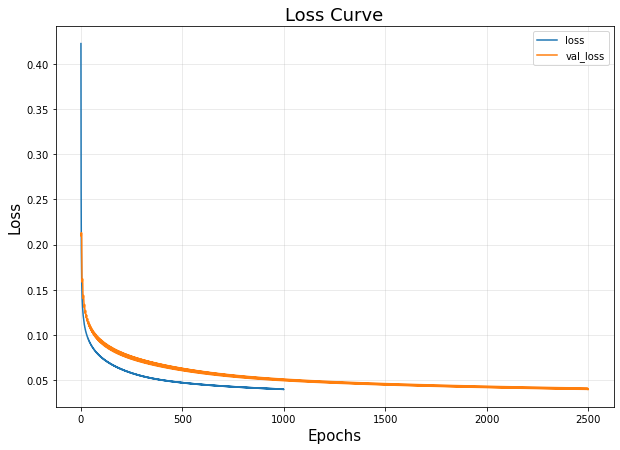

In [24]:
# Defining Figure
f = plt.figure(figsize=(10,7))
f.add_subplot()


#Adding Subplot
plt.plot(range(len(history_loss)), history_loss, label = "loss") # Loss curve for training set
plt.plot(range(len(history_val_loss)), history_val_loss, label = "val_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("Loss_curve.png")
plt.show()

### Inference on train dataset

images_color:  torch.Size([100, 3, 32, 32])


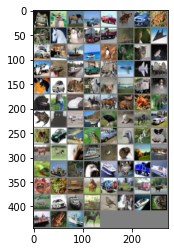

images_gray:  torch.Size([100, 32, 32])


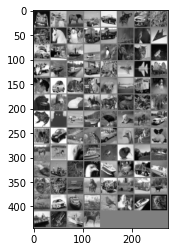

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


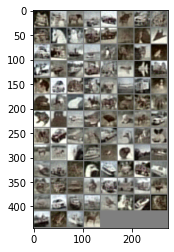

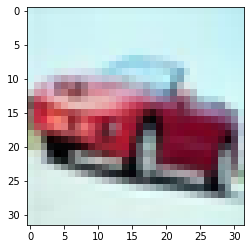

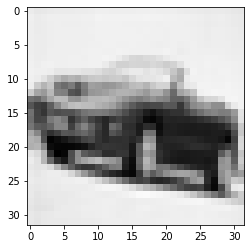

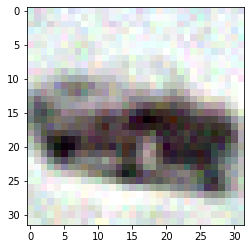

In [37]:

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(batchSize,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [4,3072]
images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print(outputs.shape)

images_color = outputs.reshape(batchSize,3,32,32)
print(images_color.shape)

images_gray = images_gray.to("cpu")
images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))

imshow(torchvision.utils.make_grid(images_color_show[4].detach()))
imshow(torchvision.utils.make_grid(images_gray[4].detach()))
imshow(torchvision.utils.make_grid(images_color[4].detach()))

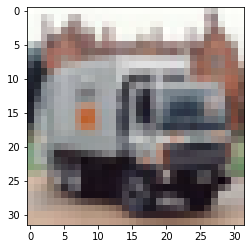

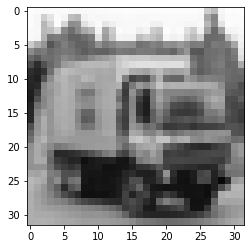

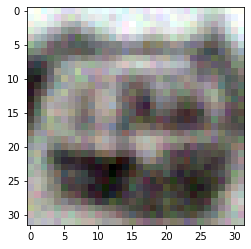

In [43]:
imshow(torchvision.utils.make_grid(images_color_show[11].detach()))
imshow(torchvision.utils.make_grid(images_gray[11].detach()))
imshow(torchvision.utils.make_grid(images_color[11].detach()))

### Save the model

In [ ]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
    
torch.save(mlp_net.state_dict(), './saved_model/mlp.pt')

### Inference on validation dataset

images_color:  torch.Size([100, 3, 32, 32])


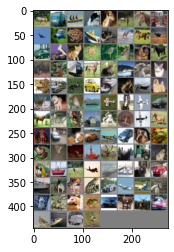

images_gray:  torch.Size([100, 32, 32])


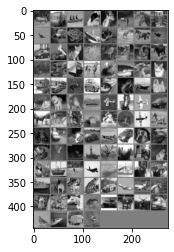

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


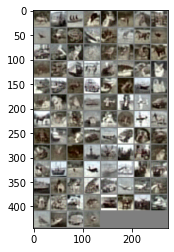

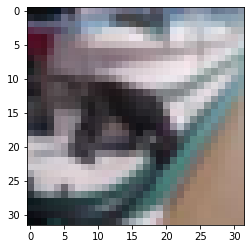

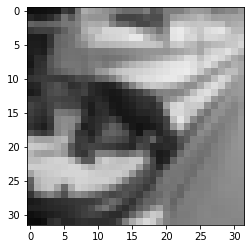

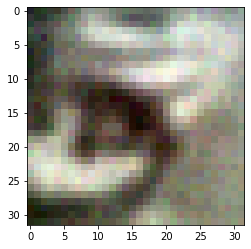

In [39]:
# get some random training images
dataiter = iter(valloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(batchSize,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [4,3072]
images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print(outputs.shape)

images_color = outputs.reshape(batchSize,3,32,32)
print(images_color.shape)

images_gray = images_gray.to("cpu")
images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))

imshow(torchvision.utils.make_grid(images_color_show[36].detach()))
imshow(torchvision.utils.make_grid(images_gray[36].detach()))
imshow(torchvision.utils.make_grid(images_color[36].detach()))


### Inference on test dataset

images_color:  torch.Size([100, 3, 32, 32])


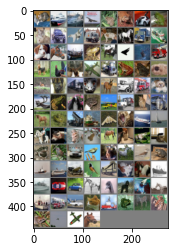

images_gray:  torch.Size([100, 32, 32])


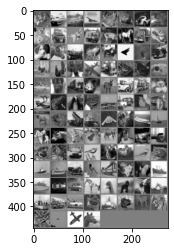

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


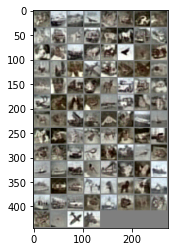

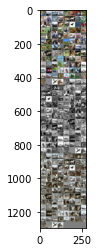

In [40]:
# get some random training images
dataiter = iter(testloader_color)
images_color, labels_color = dataiter.next()
print("images_color: ", images_color.shape)
# show images
images_color_show = images_color.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(images_color_show.detach()))

images_gray = rgb2gray_batch(images_color)
print("images_gray: ", images_gray.shape)
# show images
images_gray = images_gray.reshape(batchSize,1,32,32)
imshow(torchvision.utils.make_grid(images_gray.detach()))

# run inference on the network
# oututs [batchSize,3072]
images_gray = images_gray.to(device)
outputs = mlp_net(images_gray)
print(outputs.shape)

images_color = outputs.reshape(batchSize,3,32,32)
print(images_color.shape)

images_color = images_color.to("cpu")
imshow(torchvision.utils.make_grid(images_color.detach()))

images_gray = images_gray.to("cpu")
images_gray = torch.cat((images_gray, images_gray, images_gray), 1)

final_result_display = torch.cat((images_color_show, images_gray, images_color), 0)
imshow(torchvision.utils.make_grid(final_result_display.detach()))


In [ ]:
print(batchSize)